Imports

In [72]:
import tensorflow as tf
#from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix
import itertools

Dataset

In [107]:
# classes we'll use are 1, 4, 8
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

bad_indexes = []
for i in range(len(train_data)):
  if train_labels[i] != 1 and train_labels[i] != 4 and train_labels[i] != 8:
    bad_indexes.append(i)

train_data = np.delete(train_data, bad_indexes, axis=0)
train_labels = np.delete(train_labels, bad_indexes, axis=0)
print(train_labels.shape)

bad_indexes = []
for i in range(len(test_data)):
  if test_labels[i] != 1 and test_labels[i] != 4 and test_labels[i] != 8:
    bad_indexes.append(i)
test_data = np.delete(test_data, bad_indexes, axis=0)
test_labels = np.delete(test_labels, bad_indexes, axis=0)
print(test_data.shape)

train_data = train_data / 255.0
test_data = test_data / 255.0

class_names = ['Trouser', 'Coat', 'Bag']

(18000,)
(3000, 28, 28)


Neural network

In [112]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),  #input layer
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 2
  tf.keras.layers.Dense(10, activation="softmax") # ouput layer
])

# 2. Compile the model
model.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.002),
                metrics=['accuracy'])

# Create a learning rate scheduler callback
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# 3. Fit the model
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    verbose=0,
                    validation_data=(test_data, test_labels),
#                    callbacks=[lr_scheduler]
                    )
loss, accuracy = model.evaluate(train_data, train_labels)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


563/563 [==============================] - 1s 1ms/step - loss: 0.0252 - accuracy: 0.9923


Show results

Model loss on the test set: 0.02523435465991497
Model accuracy on the test set: 99.23%


Text(0.5, 1.0, 'Model training curves')

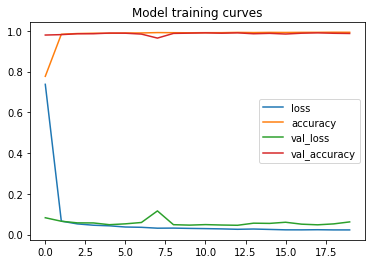

In [113]:
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

## Plot the decision boundaries for the training and test sets
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Train")
# plot_decision_boundary(model, X=train_data, y=train_labels)
# plt.subplot(1, 2, 2)
# plt.title("Test")
# plot_decision_boundary(model, X=test_data, y=test_labels)
# plt.show()

#print(pd.DataFrame(history.history))
pd.DataFrame(history.history).plot()
plt.title("Model training curves")

Learning rate vs loss

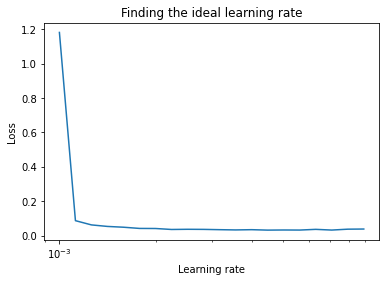

In [111]:
# Plot the learning rate versus the loss
lrs = 1e-3 * (10**(np.arange(20)/20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

Confusion matrix

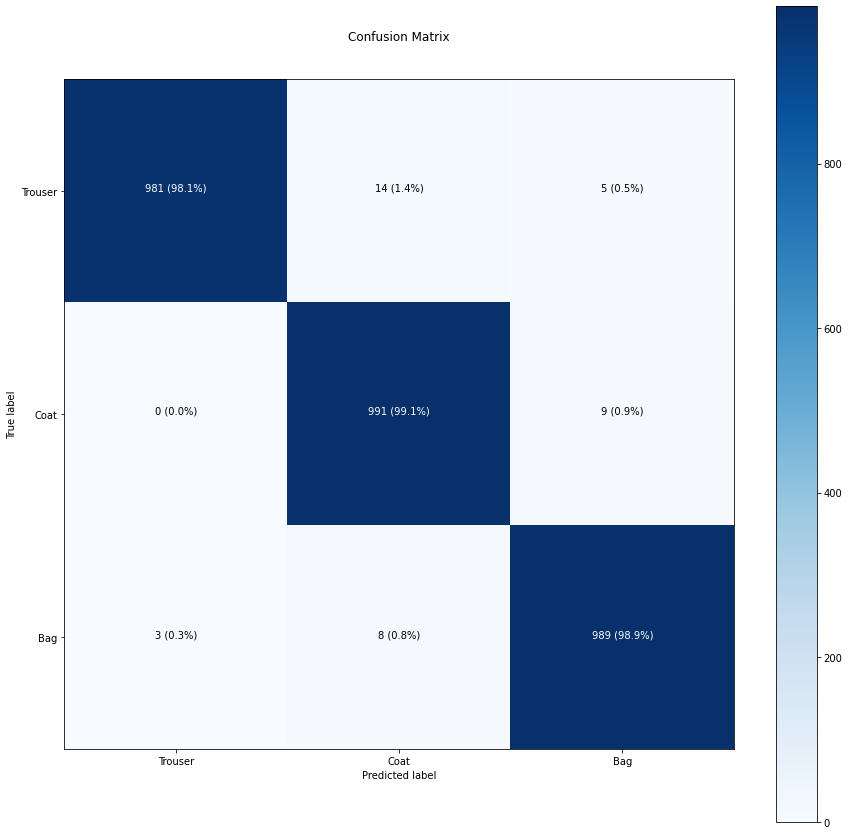

In [114]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

y_probs = model.predict(test_data)
y_preds = y_probs.argmax(axis=1)
make_confusion_matrix(y_true=test_labels, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)